THE DATASET CAN BE DOWNLOAD ON 

https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import string
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Dropout, TextVectorization, Embedding, LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


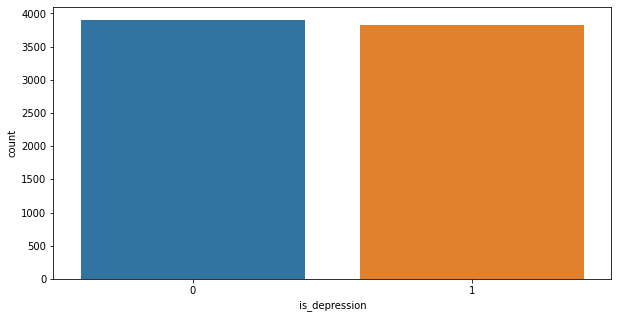

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(x="is_depression", data=df)
plt.show()

In [6]:
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

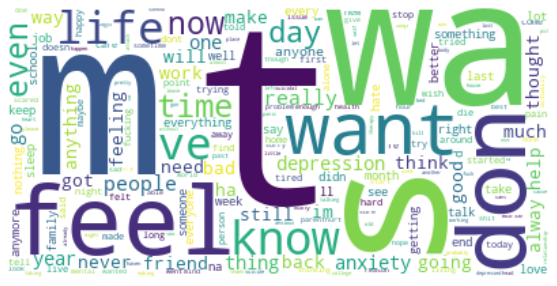

In [7]:
all_text = " ".join(text for text in df["clean_text"])

word_cloud = WordCloud(collocations=False, background_color='white').generate(all_text)
plt.figure(figsize=(15, 5))
plt.axis("off")
plt.imshow(word_cloud, interpolation='bilinear')

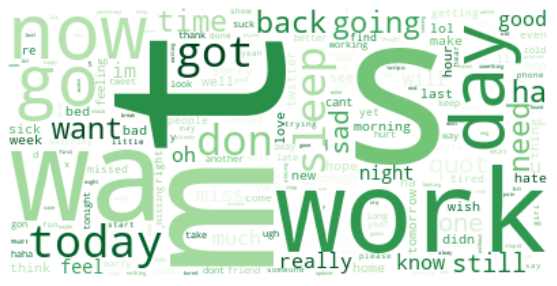

In [8]:
not_depressed_text = " ".join(text for text in df[df["is_depression"] == 0]["clean_text"])
word_cloud = WordCloud(collocations=False, background_color='white', colormap="Greens").generate(not_depressed_text)

plt.figure(figsize=(15, 5))
plt.axis("off")
plt.imshow(word_cloud, interpolation='bilinear')

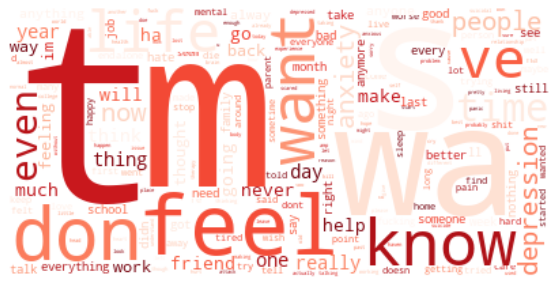

In [9]:
depressed_text = " ".join(text for text in df[df["is_depression"] == 1]["clean_text"])
word_cloud = WordCloud(collocations=False, background_color='white', colormap="Reds").generate(depressed_text)

plt.figure(figsize=(15, 5))
plt.axis("off")
plt.imshow(word_cloud, interpolation='bilinear')

In [16]:
punc = string.punctuation

# Menghilangkan tanda baca
df["clean_text"] = df["clean_text"].str.translate(str.maketrans('', '', punc))

# Membuat huruf kapital menjadi huruf kecil
df["clean_text"] = df["clean_text"].str.lower()

# Menghilangkan spasi berlebih
df["clean_text"] = df["clean_text"].str.strip()

# stemming
stemmer = PorterStemmer()
df["clean_text"] = df["clean_text"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

# stopword removal
stop_words = stopwords.words("english")
df["clean_text"] = df["clean_text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

df["clean_text"]

0       understand peopl repli immedi op invit talk pr...
1       welcom r depress check post place take moment ...
2       anyon el instead sleep depress stay night avoi...
3       kind stuf around lot life delay inevit work jo...
4       sleep greatest comfort escap whenev wake day l...
                              ...                        
7726                                                 snow
7727                              moulin roug mad cri onc
7728                            tri shout find peopl list
7729    ughh find red sox hat got ta wear thi creepi n...
7730    slept wonder final tri swatch new project clas...
Name: clean_text, Length: 7731, dtype: object

In [17]:
X, y = df["clean_text"], df["is_depression"]

In [18]:
np.random.seed(42)

prob = [0.5, 0.5]
y_pred_naive = np.random.choice([0, 1], len(y), p=prob)
print(classification_report(y, y_pred_naive))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      3900
           1       0.50      0.50      0.50      3831

    accuracy                           0.51      7731
   macro avg       0.51      0.51      0.51      7731
weighted avg       0.51      0.51      0.51      7731



In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
MAX_LENGTH = int(np.sum([len(x.split()) for x in X_train]) / len(X_train)) # rata-rata panjang kalimat

vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=MAX_LENGTH, output_mode="int")
vectorizer.adapt(X_train)

vectorizer.get_vocabulary()[:15]

['',
 '[UNK]',
 'thi',
 'feel',
 'wa',
 'like',
 'get',
 'go',
 'want',
 'know',
 'life',
 'time',
 'depress',
 'becau',
 'even']

In [21]:
vectorizer("i feel depress")

<tf.Tensor: shape=(36,), dtype=int64, numpy=
array([ 1,  3, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])>

In [22]:
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = Embedding(input_dim=10000, output_dim=128, input_length=MAX_LENGTH)(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32)(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 36)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 36, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 36, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                             

In [23]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
155/155 [==============================] - 10s 42ms/step - loss: 0.3172 - accuracy: 0.8824 - val_loss: 0.1544 - val_accuracy: 0.9450
Epoch 2/5
155/155 [==============================] - 6s 37ms/step - loss: 0.1107 - accuracy: 0.9701 - val_loss: 0.1226 - val_accuracy: 0.9596
Epoch 3/5
155/155 [==============================] - 6s 42ms/step - loss: 0.0645 - accuracy: 0.9808 - val_loss: 0.1974 - val_accuracy: 0.9386
Epoch 4/5
155/155 [==============================] - 6s 39ms/step - loss: 0.0444 - accuracy: 0.9873 - val_loss: 0.2086 - val_accuracy: 0.9378
Epoch 5/5
155/155 [==============================] - 6s 38ms/step - loss: 0.0412 - accuracy: 0.9895 - val_loss: 0.1730 - val_accuracy: 0.9410


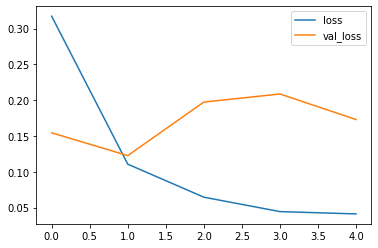

In [24]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

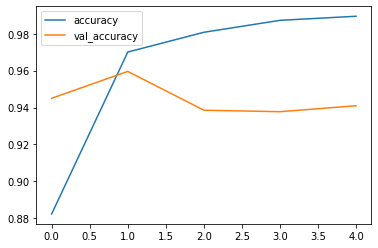

In [25]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

In [26]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

print(classification_report(y_test,y_pred))

49/49 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       783
           1       0.96      0.93      0.95       764

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547

